In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from src.data.make_dataset import make_cat_dict,calc_reactor_metrics
from src.models.constants import Constants
from src.models.util import generate_grid,split,EI,generate_prediction_array,GP_regressor
from src.models.gaussian_process import featurize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error,pairwise_distances
import scipy.stats as ss

In [39]:
plt.style.use('seaborn-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Incl. Rnd 1",3:"Incl. Rnd 2",4:"Incl. Rnd 3",5:"Incl. Rnd 4"}

In [10]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Incl. Rnd 1",3:"Incl. Rnd 2",4:"Incl. Rnd 3",5:"Incl. Rnd 4"}

In [40]:
def avg(df):
    print("Performing averaging")
    print(f'Currently {len(df)} catalyst samples in matrix.')
    metals_to_avg_on = Constants().ALL_TESTED_METALS
    df['idx'] = df.index
    columns_to_retain = Constants().METRICS
    columns_to_retain.append("idx")
    df_avg = df.groupby(Constants().ALL_TESTED_METALS)[columns_to_retain].mean().reset_index()
    df_avg=df_avg.sort_values("idx")
    df_avg.head()
    sd_pct_lifetime = .176
    sd_pct_Y_pc = .033/2
    sd_pct_sqrtY0Y_pc = .033/2 #placeholder
    df_avg["lifetime_yield_sd"] = df_avg["lifetime_yield"]*sd_pct_lifetime #producing an estimated SD for a parameter
    df_avg["Y_pc_sd"] = df_avg["Y_pc"]*sd_pct_Y_pc #producing an estimated SD for a parameter
    df_avg["sqrtY0Y_pc_sd"] = df_avg["sqrtY0Y_pc"]*sd_pct_sqrtY0Y_pc
    df_avg = df_avg.drop(columns=["idx"])
    return df_avg

The purpose of this notebook is to perform interpretations of the gaussian process model we've developed to understand why the incorporation of new data in rounds 3-4 didn't lead to an improvement in model performance.

# 1) Leave-One-Out Cross-Validation (LOO-CV) Bar Chart

First let's assess how the LOO-CV scores change for each round. For each score we report a 'normalized' score that divides the score value by the average in the dataset.

In [52]:
#load in reactor data
label_list = []
res_list = []

for n in range(1,6,1):
    for metric in ["sqrtY0Ypc_0-240"]:
        fname = f'2-cleanedup_Round{n}-Standardized.csv'
        f = processed_dir+"/"+fname
        df = pd.read_csv(f,index_col=0)
        df = avg(df) #average with index
        df_features,df_targets = featurize(df)
        X = df_features.to_numpy()
        if metric == "sqrtY0Ypc_0-240":
            Y_pc = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*0))
            chosen_metric = np.sqrt(df_targets['Y0']*Y_pc).to_numpy()
        elif metric == "sqrtY0Ypc_10-240":
            Y_pc = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*10))
            chosen_metric = np.sqrt(df_targets['Y0']*Y_pc).to_numpy()
        elif metric == "0-inf":
            Y_pc = df_targets['Y0']/df_targets['k_d']
            chosen_metric = np.sqrt(df_targets['Y0']*Y_pc).to_numpy()  
        elif metric == "Ypc_0-240":
            chosen_metric = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*0))
        elif metric == "Ypc_10-240":
            chosen_metric = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*10))
        y = chosen_metric
        y = np.asarray([[i,0] for i in y])
        print(f'Round {n} Total data points: {len(df_features)}')
        loo = LeaveOneOut().split(X,y=y)
        results = []
        for i, (i_train,i_test) in enumerate(loo):
            mu,sigma = GP_regressor(X[i_train],y[i_train],X[i_test],verbose=False)
            results.append((i_test,y[i_test,0],mu,sigma))

        all_expt = np.asarray([tup[1] for tup in results])
        all_pred = np.asarray([tup[2] for tup in results])

        if n == 1:
            expt=all_expt[:,0]
            pred=all_pred[:,0]
        else:
            expt=all_expt[:-(n-1)*6,0]
            pred=all_pred[:-(n-1)*6,0]
            new_expt=all_expt[-6:] #separate out new points
            new_pred = all_pred[-6:] #separate out new points
        print(f'Round {n} Total tested points: {len(expt)}')
        mae = np.mean(np.abs(pred-expt))
        slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
        r2 = r_value**2
        rmse = np.sqrt(mean_squared_error(expt,pred))
        mae_norm = np.mean(np.abs(pred-expt)/expt)
        rmse_norm = rmse / np.mean(expt)
        label=f'Round {n} Metric {metric} GP Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
        res = {'n':n,'metric':metric,'mae_norm':mae_norm,'rmse_norm':rmse_norm,'r2':r2}
        res_list.append(res)
        label_list.append(label)
print('\n-------------------------------------------------------------------------\n')
for label in label_list:
    print(label)

Performing averaging
Currently 40 catalyst samples in matrix.
Round 1 Total data points: 26
Round 1 Total tested points: 26
Performing averaging
Currently 46 catalyst samples in matrix.
Round 2 Total data points: 32
Round 2 Total tested points: 26
Performing averaging
Currently 52 catalyst samples in matrix.
Round 3 Total data points: 38
Round 3 Total tested points: 26
Performing averaging
Currently 58 catalyst samples in matrix.
Round 4 Total data points: 44
Round 4 Total tested points: 26
Performing averaging
Currently 64 catalyst samples in matrix.
Round 5 Total data points: 50
Round 5 Total tested points: 26

-------------------------------------------------------------------------

Round 1 Metric sqrtY0Ypc_0-240 GP Norm_MAE 0.621 Norm_RMSE 0.556 R2: 0.202
Round 2 Metric sqrtY0Ypc_0-240 GP Norm_MAE 0.58 Norm_RMSE 0.502 R2: 0.233
Round 3 Metric sqrtY0Ypc_0-240 GP Norm_MAE 0.538 Norm_RMSE 0.424 R2: 0.39
Round 4 Metric sqrtY0Ypc_0-240 GP Norm_MAE 0.544 Norm_RMSE 0.418 R2: 0.41
Round 5

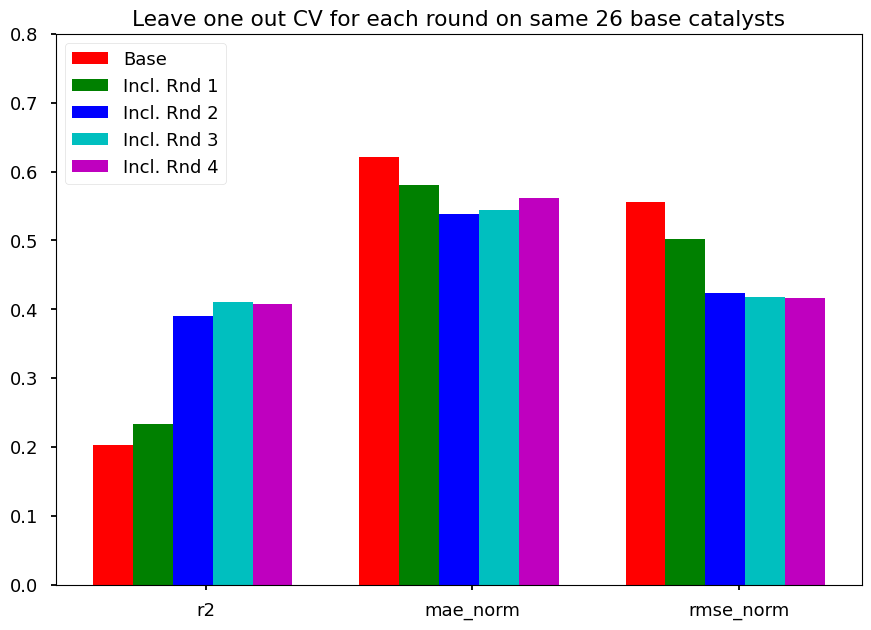

In [53]:
width = .15
scores = {"mae_norm":1,"rmse_norm":2,"r2":0}

color_list = ['r','g','b','c','m']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['mae_norm','rmse_norm','r2']):
 
    for res in res_list:
        if val == "mae_norm":
            ax.bar(scores[val]+width*res["n"],res[val],width=width,color=color_list[res["n"]-1],label=f'{n_map[res["n"]]}')
        else:
            ax.bar(scores[val]+width*res["n"],res[val],width=width,color=color_list[res["n"]-1])
            

    plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
    plt.title("Leave one out CV for each round on same 26 base catalysts")
    plt.legend(loc='upper left')
    plt.ylim((0,.8))
plt.show()



At first the model is appearing to learn, increasing its r2 and decreasing its normalized error. But when we include round 3 data something changes. Now the model appears to have less accurate predictive capacity. Let's see if we can dive deeper into why.

# 2) Assessing parity plots

Next let's look at the parity plot for the new data produced in each round. 

In [41]:
results = []

for n in range(2,6,1):
    for metric in ["sqrtY0Ypc_0-240"]:
        fname = f'2-cleanedup_Round{n}-Standardized.csv'
        f = processed_dir+"/"+fname
        df = pd.read_csv(f,index_col=0)
        df = avg(df) #average with index
        df_features,df_targets = featurize(df)
        X = df_features.to_numpy()
        Y_pc = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*0))
        chosen_metric = np.sqrt(df_targets['Y0']*Y_pc).to_numpy()
        y = chosen_metric
        y = np.asarray([[val,0] for val in y])    

        if n == 1:
            X_train =X[:]
            y_train =y[:]
        else:
            X_train=X[:-6]
            y_train=y[:-6]
            X_test=X[-6:] #separate out new points
            y_test = y[-6:] #separate out new points

        mu,sigma = GP_regressor(X_train,y_train,X_test,verbose=False)
        y_train = y_train[:,0]
        y_test = y_test[:,0]
        results.append({'n':n,'mu':mu,'sigma':sigma,'X_train':X_train,'y_train':y_train,'X_test':X_test,'y_test':y_test})
        print(f'Round {n-1}: Training Points: {len(X_train)} Testing Points: {len(X_test)}')

Performing averaging
Currently 46 catalyst samples in matrix.
Round 1: Training Points: 26 Testing Points: 6
Performing averaging
Currently 52 catalyst samples in matrix.
Round 2: Training Points: 32 Testing Points: 6
Performing averaging
Currently 58 catalyst samples in matrix.
Round 3: Training Points: 38 Testing Points: 6
Performing averaging
Currently 64 catalyst samples in matrix.
Round 4: Training Points: 44 Testing Points: 6


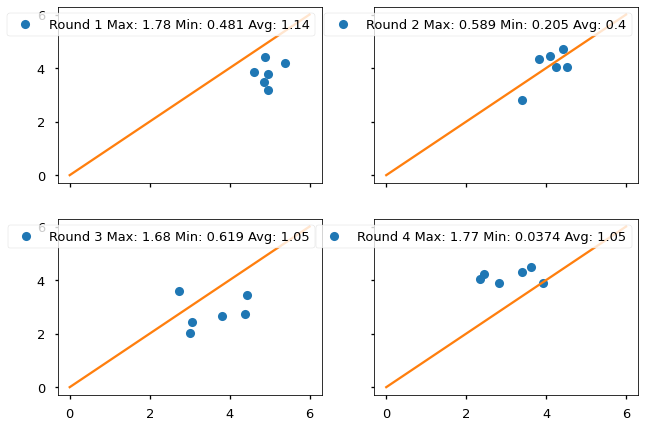

In [44]:
fig,axs = plt.subplots(2,2,sharex=True,sharey=True)
k=0
for i in range(2):
    for j in range(2):
        resids = results[k]['mu'] - results[k]['y_test']
        resids = np.abs(resids)
        
        axs[i,j].plot(results[k]['mu'],results[k]['y_test'],'o',label=f'Round {k+1} Max: {np.max(resids):.3} Min: {np.min(resids):.3} Avg: {np.average(resids):.3}')
        axs[i,j].plot(np.arange(7),np.arange(7))
        axs[i,j].legend()
        k += 1
        

All the parity plots look pretty good. What's the predictive accuracy for these?

In [ ]:
width = .15
scores = {"mae_norm":1,"rmse_norm":2,"r2":0}

color_list = ['r','g','b','c','m']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['mae_norm','rmse_norm','r2']):
 
    for res in res_list:
        if val == "mae_norm":
            ax.bar(scores[val]+width*res["n"],res[val],width=width,color=color_list[res["n"]-1],label=f'{n_map[res["n"]]}')
        else:
            ax.bar(scores[val]+width*res["n"],res[val],width=width,color=color_list[res["n"]-1])
            

    plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
    plt.title("Leave one out CV for each round on same 26 base catalysts")
    plt.legend(loc='upper left')
    plt.ylim((0,.8))
plt.show()



# 3) Analyzing model predictions

We need to get a better handle on what types of data our model predicts well and not well for. Let's make a dataset that we can view in Excel.

In [59]:
fname = f'2-cleanedup_Round{5}-Standardized.csv'
f = processed_dir+"/"+fname
df = pd.read_csv(f,index_col=0)
df = avg(df) #average with index
df_features,df_targets = featurize(df)
X = df_features.to_numpy()
Y_pc = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*0))
chosen_metric = np.sqrt(df_targets['Y0']*Y_pc).to_numpy()
y = chosen_metric
y = np.asarray([[i,0] for i in y])
print(f'Round {n} Total data points: {len(df_features)}')
loo = LeaveOneOut().split(X,y=y)
mus = []
sigmas = []
for i, (i_train,i_test) in enumerate(loo):
    mu,sigma = GP_regressor(X[i_train],y[i_train],X[i_test],verbose=False)
    mus.append(mu)
    sigmas.append(sigma)
    
df["loo-cv_pred_mu"] = np.asarray(mus)
df["loo-cv_pred_sigma"] = np.asarray(sigmas)
df_metals = df[Constants().METALS]
distance_matrix = pairwise_distances(df_metals.to_numpy())
df['euclidean_distance'] = np.mean(distance_matrix,axis=1)
df['residual'] = df["loo-cv_pred_mu"]-df['sqrtY0Y_pc']
df['abs_residual'] = np.abs(df['residual'])

Performing averaging
Currently 64 catalyst samples in matrix.
Round 5 Total data points: 50


Text(0, 0.5, '|Residual|')

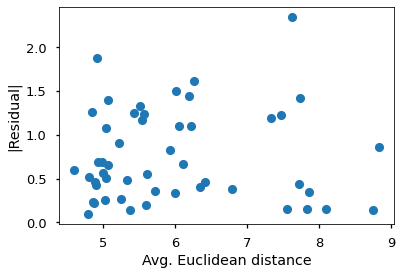

In [61]:
plt.plot(df['euclidean_distance'],df['abs_residual'],"o")
plt.xlabel("Avg. Euclidean distance")
plt.ylabel("|Residual|")

In [62]:
df.to_csv("notebook6_rnd5_analysis_matrix.csv")